In [1]:
import numpy as np
import torch
import torch.nn as nn
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp 
sp.init_printing(use_latex=True)
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:", torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

NVIDIA GeForce RTX 2080 Ti
_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
Number of devices: 1


In [3]:
# Config Section
cfg_data_folder = "datasets/cifar10"
cfg_batch_size  = 250
cfg_max_epochs  = 10;
cfg_num_workers = 2

# Logger Config
cfg_logger_dir    ="logs"
cfg_logger_name   ="OL3"
cfg_logger_version="gelu"


In [4]:
# CIFAR 10
training_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder, download=True, train=True)
testing_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder,  download=True, train=False)

# Training
x_train = torch.Tensor(training_dataset.data).permute(0, 3, 1, 2)
y_train = torch.Tensor(training_dataset.targets).to(torch.long)

# Validation / Testing Data
x_test = torch.Tensor(testing_dataset.data).permute(0, 3, 1 ,2)
y_test = torch.Tensor(testing_dataset.targets).to(torch.long)

# Shape of Cifar10
print(x_train.shape)
print(x_test.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


In [5]:
xy_train = torch.utils.data.DataLoader(list(zip(x_train,
                                                y_train)),
                                       shuffle=True,
                                       batch_size=cfg_batch_size,
                                       num_workers=cfg_num_workers)

xy_val = torch.utils.data.DataLoader(list(zip(x_test,
                                              y_test)), 
                                     shuffle=False,
                                     batch_size=cfg_batch_size,
                                     num_workers=cfg_num_workers)

In [6]:
# Shapes
print(f"x_train.show() => {x_train.shape}")
print(f"y_train.show() => {y_train.shape}")
print(f"np.unique(y_train) => {np.unique(y_train)}")

x_train.show() => torch.Size([50000, 3, 32, 32])
y_train.show() => torch.Size([50000])
np.unique(y_train) => [0 1 2 3 4 5 6 7 8 9]


In [7]:
x_train[0]

tensor([[[ 59.,  43.,  50.,  ..., 158., 152., 148.],
         [ 16.,   0.,  18.,  ..., 123., 119., 122.],
         [ 25.,  16.,  49.,  ..., 118., 120., 109.],
         ...,
         [208., 201., 198.,  ..., 160.,  56.,  53.],
         [180., 173., 186.,  ..., 184.,  97.,  83.],
         [177., 168., 179.,  ..., 216., 151., 123.]],

        [[ 62.,  46.,  48.,  ..., 132., 125., 124.],
         [ 20.,   0.,   8.,  ...,  88.,  83.,  87.],
         [ 24.,   7.,  27.,  ...,  84.,  84.,  73.],
         ...,
         [170., 153., 161.,  ..., 133.,  31.,  34.],
         [139., 123., 144.,  ..., 148.,  62.,  53.],
         [144., 129., 142.,  ..., 184., 118.,  92.]],

        [[ 63.,  45.,  43.,  ..., 108., 102., 103.],
         [ 20.,   0.,   0.,  ...,  55.,  50.,  57.],
         [ 21.,   0.,   8.,  ...,  50.,  50.,  42.],
         ...,
         [ 96.,  34.,  26.,  ...,  70.,   7.,  20.],
         [ 96.,  42.,  30.,  ...,  94.,  34.,  34.],
         [116.,  94.,  87.,  ..., 140.,  84.,  72.]]]

In [8]:
x_train[0].permute(1,2,0)

tensor([[[ 59.,  62.,  63.],
         [ 43.,  46.,  45.],
         [ 50.,  48.,  43.],
         ...,
         [158., 132., 108.],
         [152., 125., 102.],
         [148., 124., 103.]],

        [[ 16.,  20.,  20.],
         [  0.,   0.,   0.],
         [ 18.,   8.,   0.],
         ...,
         [123.,  88.,  55.],
         [119.,  83.,  50.],
         [122.,  87.,  57.]],

        [[ 25.,  24.,  21.],
         [ 16.,   7.,   0.],
         [ 49.,  27.,   8.],
         ...,
         [118.,  84.,  50.],
         [120.,  84.,  50.],
         [109.,  73.,  42.]],

        ...,

        [[208., 170.,  96.],
         [201., 153.,  34.],
         [198., 161.,  26.],
         ...,
         [160., 133.,  70.],
         [ 56.,  31.,   7.],
         [ 53.,  34.,  20.]],

        [[180., 139.,  96.],
         [173., 123.,  42.],
         [186., 144.,  30.],
         ...,
         [184., 148.,  94.],
         [ 97.,  62.,  34.],
         [ 83.,  53.,  34.]],

        [[177., 144., 116.],
       

In [9]:
x_train[0].permute(1,2,0) / 255

tensor([[[0.2314, 0.2431, 0.2471],
         [0.1686, 0.1804, 0.1765],
         [0.1961, 0.1882, 0.1686],
         ...,
         [0.6196, 0.5176, 0.4235],
         [0.5961, 0.4902, 0.4000],
         [0.5804, 0.4863, 0.4039]],

        [[0.0627, 0.0784, 0.0784],
         [0.0000, 0.0000, 0.0000],
         [0.0706, 0.0314, 0.0000],
         ...,
         [0.4824, 0.3451, 0.2157],
         [0.4667, 0.3255, 0.1961],
         [0.4784, 0.3412, 0.2235]],

        [[0.0980, 0.0941, 0.0824],
         [0.0627, 0.0275, 0.0000],
         [0.1922, 0.1059, 0.0314],
         ...,
         [0.4627, 0.3294, 0.1961],
         [0.4706, 0.3294, 0.1961],
         [0.4275, 0.2863, 0.1647]],

        ...,

        [[0.8157, 0.6667, 0.3765],
         [0.7882, 0.6000, 0.1333],
         [0.7765, 0.6314, 0.1020],
         ...,
         [0.6275, 0.5216, 0.2745],
         [0.2196, 0.1216, 0.0275],
         [0.2078, 0.1333, 0.0784]],

        [[0.7059, 0.5451, 0.3765],
         [0.6784, 0.4824, 0.1647],
         [0.

In [10]:
new_shape = x_train[0].permute(1,2,0) / 255
new_shape.shape

torch.Size([32, 32, 3])

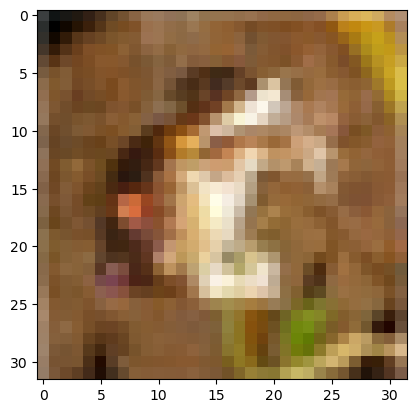

In [11]:
plt.imshow(x_train[0].permute(2,1,0) / 255.0)
plt.show()

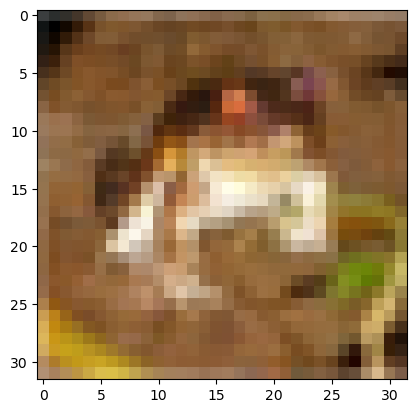

In [12]:
plt.imshow(x_train[0].permute(1,2,0) / 255.0)
plt.show()

In [13]:
y_train[0]

tensor(6)

In [14]:
x_train[0]

tensor([[[ 59.,  43.,  50.,  ..., 158., 152., 148.],
         [ 16.,   0.,  18.,  ..., 123., 119., 122.],
         [ 25.,  16.,  49.,  ..., 118., 120., 109.],
         ...,
         [208., 201., 198.,  ..., 160.,  56.,  53.],
         [180., 173., 186.,  ..., 184.,  97.,  83.],
         [177., 168., 179.,  ..., 216., 151., 123.]],

        [[ 62.,  46.,  48.,  ..., 132., 125., 124.],
         [ 20.,   0.,   8.,  ...,  88.,  83.,  87.],
         [ 24.,   7.,  27.,  ...,  84.,  84.,  73.],
         ...,
         [170., 153., 161.,  ..., 133.,  31.,  34.],
         [139., 123., 144.,  ..., 148.,  62.,  53.],
         [144., 129., 142.,  ..., 184., 118.,  92.]],

        [[ 63.,  45.,  43.,  ..., 108., 102., 103.],
         [ 20.,   0.,   0.,  ...,  55.,  50.,  57.],
         [ 21.,   0.,   8.,  ...,  50.,  50.,  42.],
         ...,
         [ 96.,  34.,  26.,  ...,  70.,   7.,  20.],
         [ 96.,  42.,  30.,  ...,  94.,  34.,  34.],
         [116.,  94.,  87.,  ..., 140.,  84.,  72.]]]

In [29]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = nn.GELU()(self.bn1(self.conv1(x)))
        out = nn.GELU()(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = nn.GELU()(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.GELU()(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AvgPool2d(4)(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

In [31]:
model = ResNet50()

summary(model, input_size=(1,)+x_train.shape[1:], depth=4)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,728
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─Sequential: 1-3                        [1, 256, 32, 32]          --
│    └─Bottleneck: 2-1                   [1, 256, 32, 32]          --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─Conv2d: 3-3                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 32, 32]           128
│    │    └─Conv2d: 3-5                  [1, 256, 32, 32]          16,384
│    │    └─BatchNorm2d: 3-6             [1, 256, 32, 32]          512
│    │    └─Sequential: 3-7              [1, 256, 32, 32]          --
│    │    │    └─Conv2d: 4-1             [1, 256, 32, 32]          

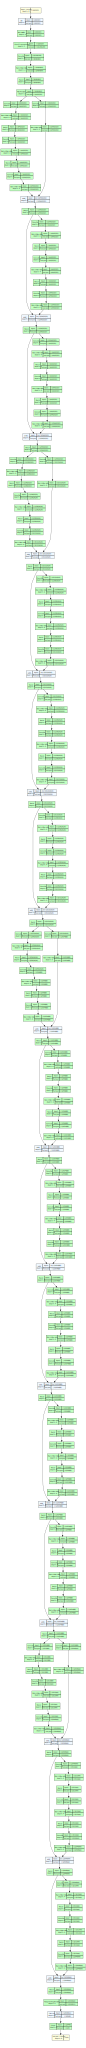

In [20]:
model_graph = draw_graph(model,
                         input_size=(1,)+x_train.shape[1:],
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False, 
                         depth=5)

model_graph.visual_graph

In [28]:
model_graph.resize_graph(scale=5.0)
model_graph.visual_graph.render(filename="relu", format='png')

'relu.png'

In [36]:
predictions = model.predict(x_train[:5].to(device)).cpu().detach().numpy()
print(predictions)

[[0.07470869 0.07140315 0.17396238 0.06927963 0.18475394 0.17941812
  0.03735022 0.06320339 0.03303654 0.11288395]
 [0.06578024 0.08195806 0.17567891 0.04531128 0.19323172 0.14820637
  0.04695115 0.05852471 0.03442813 0.14992945]
 [0.07841764 0.06669325 0.20764334 0.05805028 0.21201737 0.1442145
  0.04082927 0.05013994 0.02087153 0.12112293]
 [0.07006489 0.08533289 0.13927297 0.0860447  0.16260889 0.15426081
  0.04924427 0.07013953 0.03497873 0.1480523 ]
 [0.07621539 0.04338287 0.21283302 0.04349636 0.32593483 0.11067933
  0.04151643 0.02151237 0.01315691 0.1112725 ]]


In [37]:
predictions.shape

In [38]:
predictions.argmax(-1)

array([4, 4, 4, 4, 4])

In [39]:
y_train[:5]

tensor([6, 9, 9, 4, 1])

In [40]:
logger = pl.loggers.CSVLogger(cfg_logger_dir,
                              name=cfg_logger_name,
                              version=cfg_logger_version)

trainer = pl.Trainer(logger=logger,
                     max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [41]:
# Validate on Model
trainer.validate(model, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory logs/OL3/relu exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.09730000048875809    │
│         val_loss          │    2.3027050495147705     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.09730000048875809, 'val_loss': 2.3027050495147705}]

In [42]:
trainer.fit(model, xy_train, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | projection | ConvTranspose2d    | 147   
1 | resnet     | ResNet             | 23.5 M
2 | model_acc  | MulticlassAccuracy | 0     
3 | model_loss | CrossEntropyLoss   | 0     
--------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.115    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [43]:
trainer.validate(model, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.2842000126838684     │
│         val_loss          │    1.9460645914077759     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.2842000126838684, 'val_loss': 1.9460645914077759}]

In [44]:
results = pd.read_csv(logger.log_dir + "/metrics.csv")

In [45]:
print(results)

    val_acc  val_loss  epoch  step  train_acc  train_loss
0    0.0973  2.302705      0     0        NaN         NaN
1    0.1285  2.298741      0   199        NaN         NaN
2       NaN       NaN      0   199    0.11924    2.302988
3    0.1695  2.227148      1   399        NaN         NaN
4       NaN       NaN      1   399    0.14944    2.255399
5    0.1933  2.195993      2   599        NaN         NaN
6       NaN       NaN      2   599    0.17100    2.207395
7    0.2000  2.142237      3   799        NaN         NaN
8       NaN       NaN      3   799    0.18930    2.170903
9    0.2200  2.103724      4   999        NaN         NaN
10      NaN       NaN      4   999    0.20564    2.132029
11   0.2230  2.064103      5  1199        NaN         NaN
12      NaN       NaN      5  1199    0.21470    2.102024
13   0.2535  2.025166      6  1399        NaN         NaN
14      NaN       NaN      6  1399    0.23148    2.058892
15   0.2646  1.993792      7  1599        NaN         NaN
16      NaN   

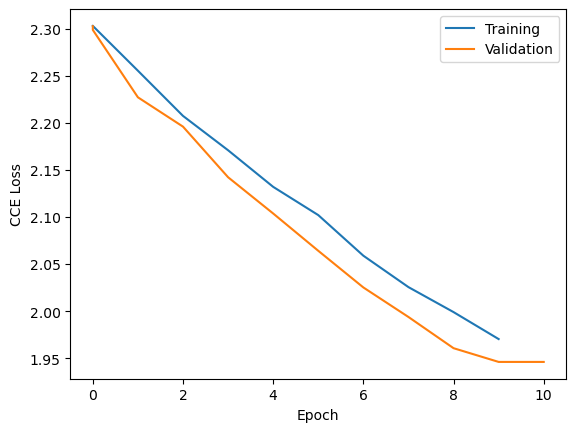

In [46]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")

plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()

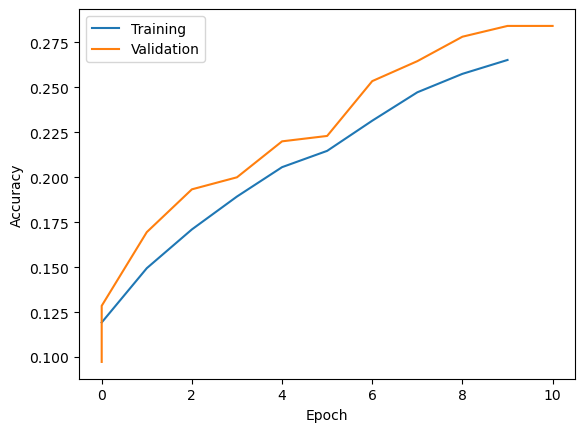

In [47]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))],
         results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))],
         results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))],
         label="Validation")

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [48]:
print("Validation accuracy:", *["%.8f"%(x) for x in results['val_acc'][np.logical_not(np.isnan(results["val_acc"]))]])

Validation accuracy: 0.09730000 0.12850000 0.16949999 0.19329999 0.20000000 0.22000000 0.22300000 0.25350001 0.26460001 0.27820000 0.28420001 0.28420001
